<a href="https://colab.research.google.com/github/chakkarinsan2/flickr30k/blob/main/Interacting_with_CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interacting with CLIP

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [1]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.9 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-1ru5oe4m
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-1ru5oe4m
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369499 sha256=003ccd484a6561f504e4b046470787a59404453ecba092a36fb51854ebe8eb87
  Stored in directory: /tmp/pip-ephem-wheel-cache-gv7w4kdw/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [2]:
pip install torch===1.7.1 torchvision===0.8.2 torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch===1.7.1 (from versions: 1.11.0, 1.11.0+cpu, 1.11.0+cu102, 1.11.0+cu113, 1.11.0+cu115, 1.11.0+rocm4.3.1, 1.11.0+rocm4.5.2, 1.12.0, 1.12.0+cpu, 1.12.0+cu102, 1.12.0+cu113, 1.12.0+cu116, 1.12.0+rocm5.0, 1.12.0+rocm5.1.1, 1.12.1, 1.12.1+cpu, 1.12.1+cu102, 1.12.1+cu113, 1.12.1+cu116, 1.12.1+rocm5.0, 1.12.1+rocm5.1.1, 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.0+cu117.with.pypi.cudnn, 1.13.0+rocm5.1.1, 1.13.0+rocm5.2, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 1.13.1+cu117.with.pypi.cudnn, 1.13.1+rocm5.1.1, 1.13.1+rocm5.2, 2.0.0, 2.0.0+cpu, 2.0.0+cpu.cxx11.abi, 2.0.0+cu117, 2.0.0+cu117.with.pypi.cudnn, 2.0.0+cu118, 2.0.0+rocm5.3, 2.0.0+rocm5.4.2, 2.0.1, 2.0.1+cpu, 2.0.1+cpu.cxx11.abi, 2.0.1+cu117, 2.0.1+cu117.with.pypi.cudnn, 2.0.1+cu118, 2.0.1+rocm5.3, 2.0.1+rocm5.4.2)
ERROR: No matching distribution found for torch===1.7.1


In [3]:
import numpy as np
import torch

print("Torch version:", torch.__version__)

assert torch.__version__.split(".") >= ["1", "7", "1"], "PyTorch 1.7.1 or later is required"

Torch version: 2.0.1+cu118


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [4]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [5]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|███████████████████████████████████████| 338M/338M [00:06<00:00, 56.2MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [6]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x788032269990>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [7]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

# Setting up input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [8]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a photo of book page",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red  bicycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer"
}

<PIL.Image.Image image mode=RGB size=640x427 at 0x788024B85840>


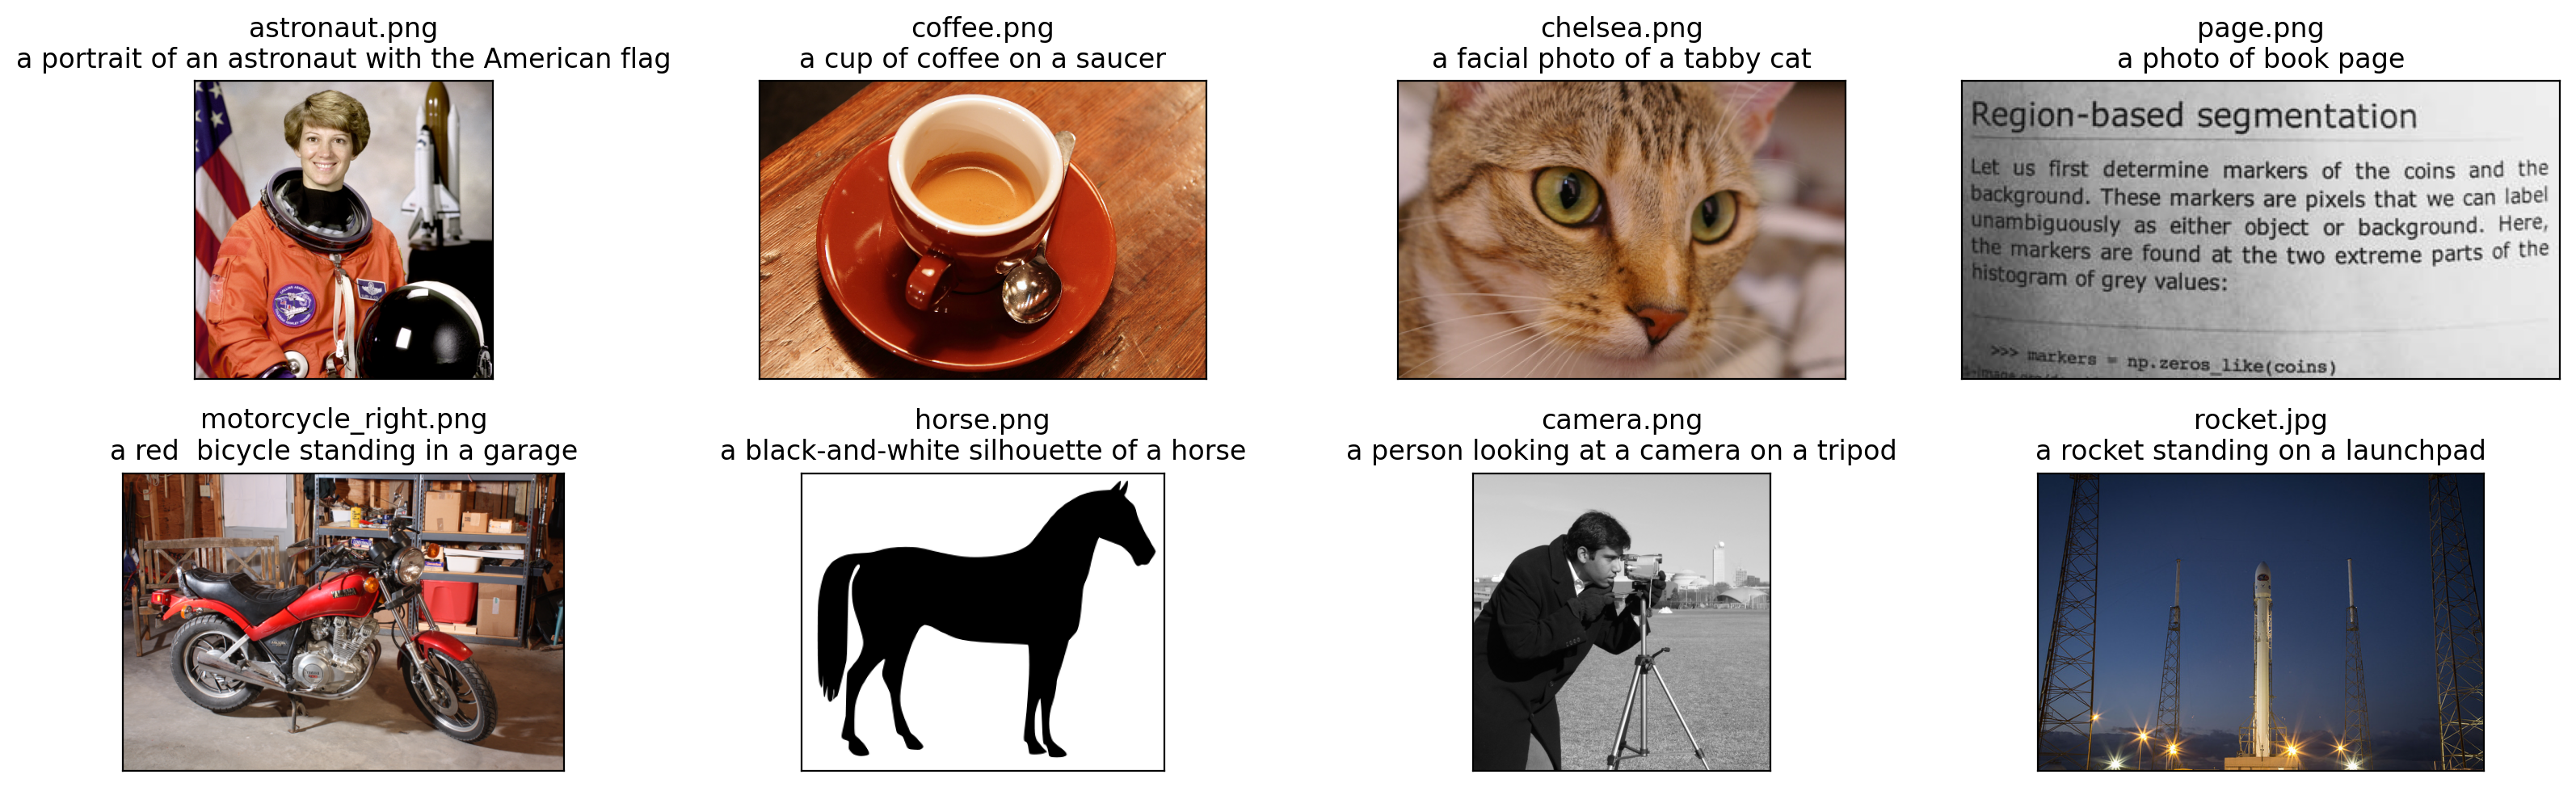

In [21]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")

    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()


## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [28]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

print(image_input)
print(text_tokens)

tensor([[[[ 0.2953, -0.3616,  0.1931,  ...,  0.0471,  0.0471,  0.0179],
          [ 1.2588,  1.0252,  1.1420,  ...,  0.0617,  0.0325,  0.0471],
          [ 1.6530,  1.5362,  1.3172,  ...,  0.0471,  0.0471,  0.0325],
          ...,
          [ 0.9230,  0.9522,  0.8501,  ..., -0.6828, -0.9018, -1.7923],
          [ 0.9230,  0.8792,  0.6749,  ..., -0.6390, -1.6755, -1.7923],
          [ 0.8938,  0.7771,  0.4997,  ..., -0.8434, -1.2667, -1.7923]],

         [[ 0.3190, -0.2963,  0.2589,  ...,  0.0338,  0.0338,  0.0038],
          [ 1.2945,  1.0694,  1.2044,  ...,  0.0038,  0.0038,  0.0038],
          [ 1.6697,  1.5796,  1.3395,  ...,  0.0188,  0.0188,  0.0038],
          ...,
          [ 0.7692,  0.8292,  0.6792,  ..., -0.7466, -0.8816, -1.7521],
          [ 0.7842,  0.7392,  0.5141,  ..., -0.6715, -1.6470, -1.7521],
          [ 0.7692,  0.6191,  0.3190,  ..., -0.8516, -1.2118, -1.7521]],

         [[ 0.5959,  0.1977,  0.4253,  ...,  0.1124,  0.1124,  0.0698],
          [ 1.3638,  1.1789,  

In [29]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

print(image_features)
print(text_features)

tensor([[ 0.3174,  0.3047, -0.1549,  ..., -0.1091, -0.2203,  0.1312],
        [ 0.1381,  0.5620, -0.1763,  ...,  0.6284,  0.1100,  0.0812],
        [-0.2812, -0.2073,  0.0348,  ...,  1.1123, -0.2537, -0.1093],
        ...,
        [-0.2455, -0.1819, -0.2000,  ...,  0.8564, -0.1382, -0.4075],
        [-0.0021, -0.0938,  0.0245,  ...,  0.2365, -0.2751,  0.2864],
        [ 0.0753,  0.2100,  0.0688,  ...,  0.0166, -0.2115, -0.5747]],
       device='cuda:0')
tensor([[-0.1664,  0.0523, -0.1534,  ...,  0.3140, -0.1360, -0.2649],
        [ 0.0858,  0.1796, -0.0430,  ...,  0.2842, -0.2739, -0.0690],
        [-0.0393, -0.0320, -0.0910,  ...,  0.2255, -0.3811, -0.4329],
        ...,
        [ 0.0724,  0.0354, -0.0347,  ...,  0.1863, -0.2830,  0.1437],
        [ 0.0591, -0.0753, -0.3896,  ..., -0.3206, -0.1188, -0.1005],
        [ 0.0687,  0.1190, -0.0774,  ...,  0.1405, -0.0836, -0.2219]],
       device='cuda:0')


## Calculating cosine similarity

We normalize the features and calculate the dot product of each pair.

In [30]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
print(image_features)
print(text_features)
print(similarity)

tensor([[ 0.0343,  0.0329, -0.0167,  ..., -0.0118, -0.0238,  0.0142],
        [ 0.0120,  0.0488, -0.0153,  ...,  0.0545,  0.0095,  0.0070],
        [-0.0246, -0.0181,  0.0030,  ...,  0.0973, -0.0222, -0.0096],
        ...,
        [-0.0221, -0.0164, -0.0180,  ...,  0.0772, -0.0124, -0.0367],
        [-0.0002, -0.0084,  0.0022,  ...,  0.0211, -0.0246,  0.0256],
        [ 0.0070,  0.0196,  0.0064,  ...,  0.0015, -0.0197, -0.0536]],
       device='cuda:0')
tensor([[-0.0194,  0.0061, -0.0179,  ...,  0.0366, -0.0159, -0.0309],
        [ 0.0093,  0.0195, -0.0047,  ...,  0.0309, -0.0298, -0.0075],
        [-0.0048, -0.0039, -0.0111,  ...,  0.0275, -0.0465, -0.0528],
        ...,
        [ 0.0092,  0.0045, -0.0044,  ...,  0.0237, -0.0359,  0.0182],
        [ 0.0063, -0.0080, -0.0412,  ..., -0.0339, -0.0126, -0.0106],
        [ 0.0077,  0.0133, -0.0086,  ...,  0.0157, -0.0093, -0.0247]],
       device='cuda:0')
[[0.2767253  0.14940494 0.1680465  0.12982427 0.15010871 0.16260761
  0.16571185 0.2

Text(0.5, 1.0, 'Cosine similarity between text and image features')

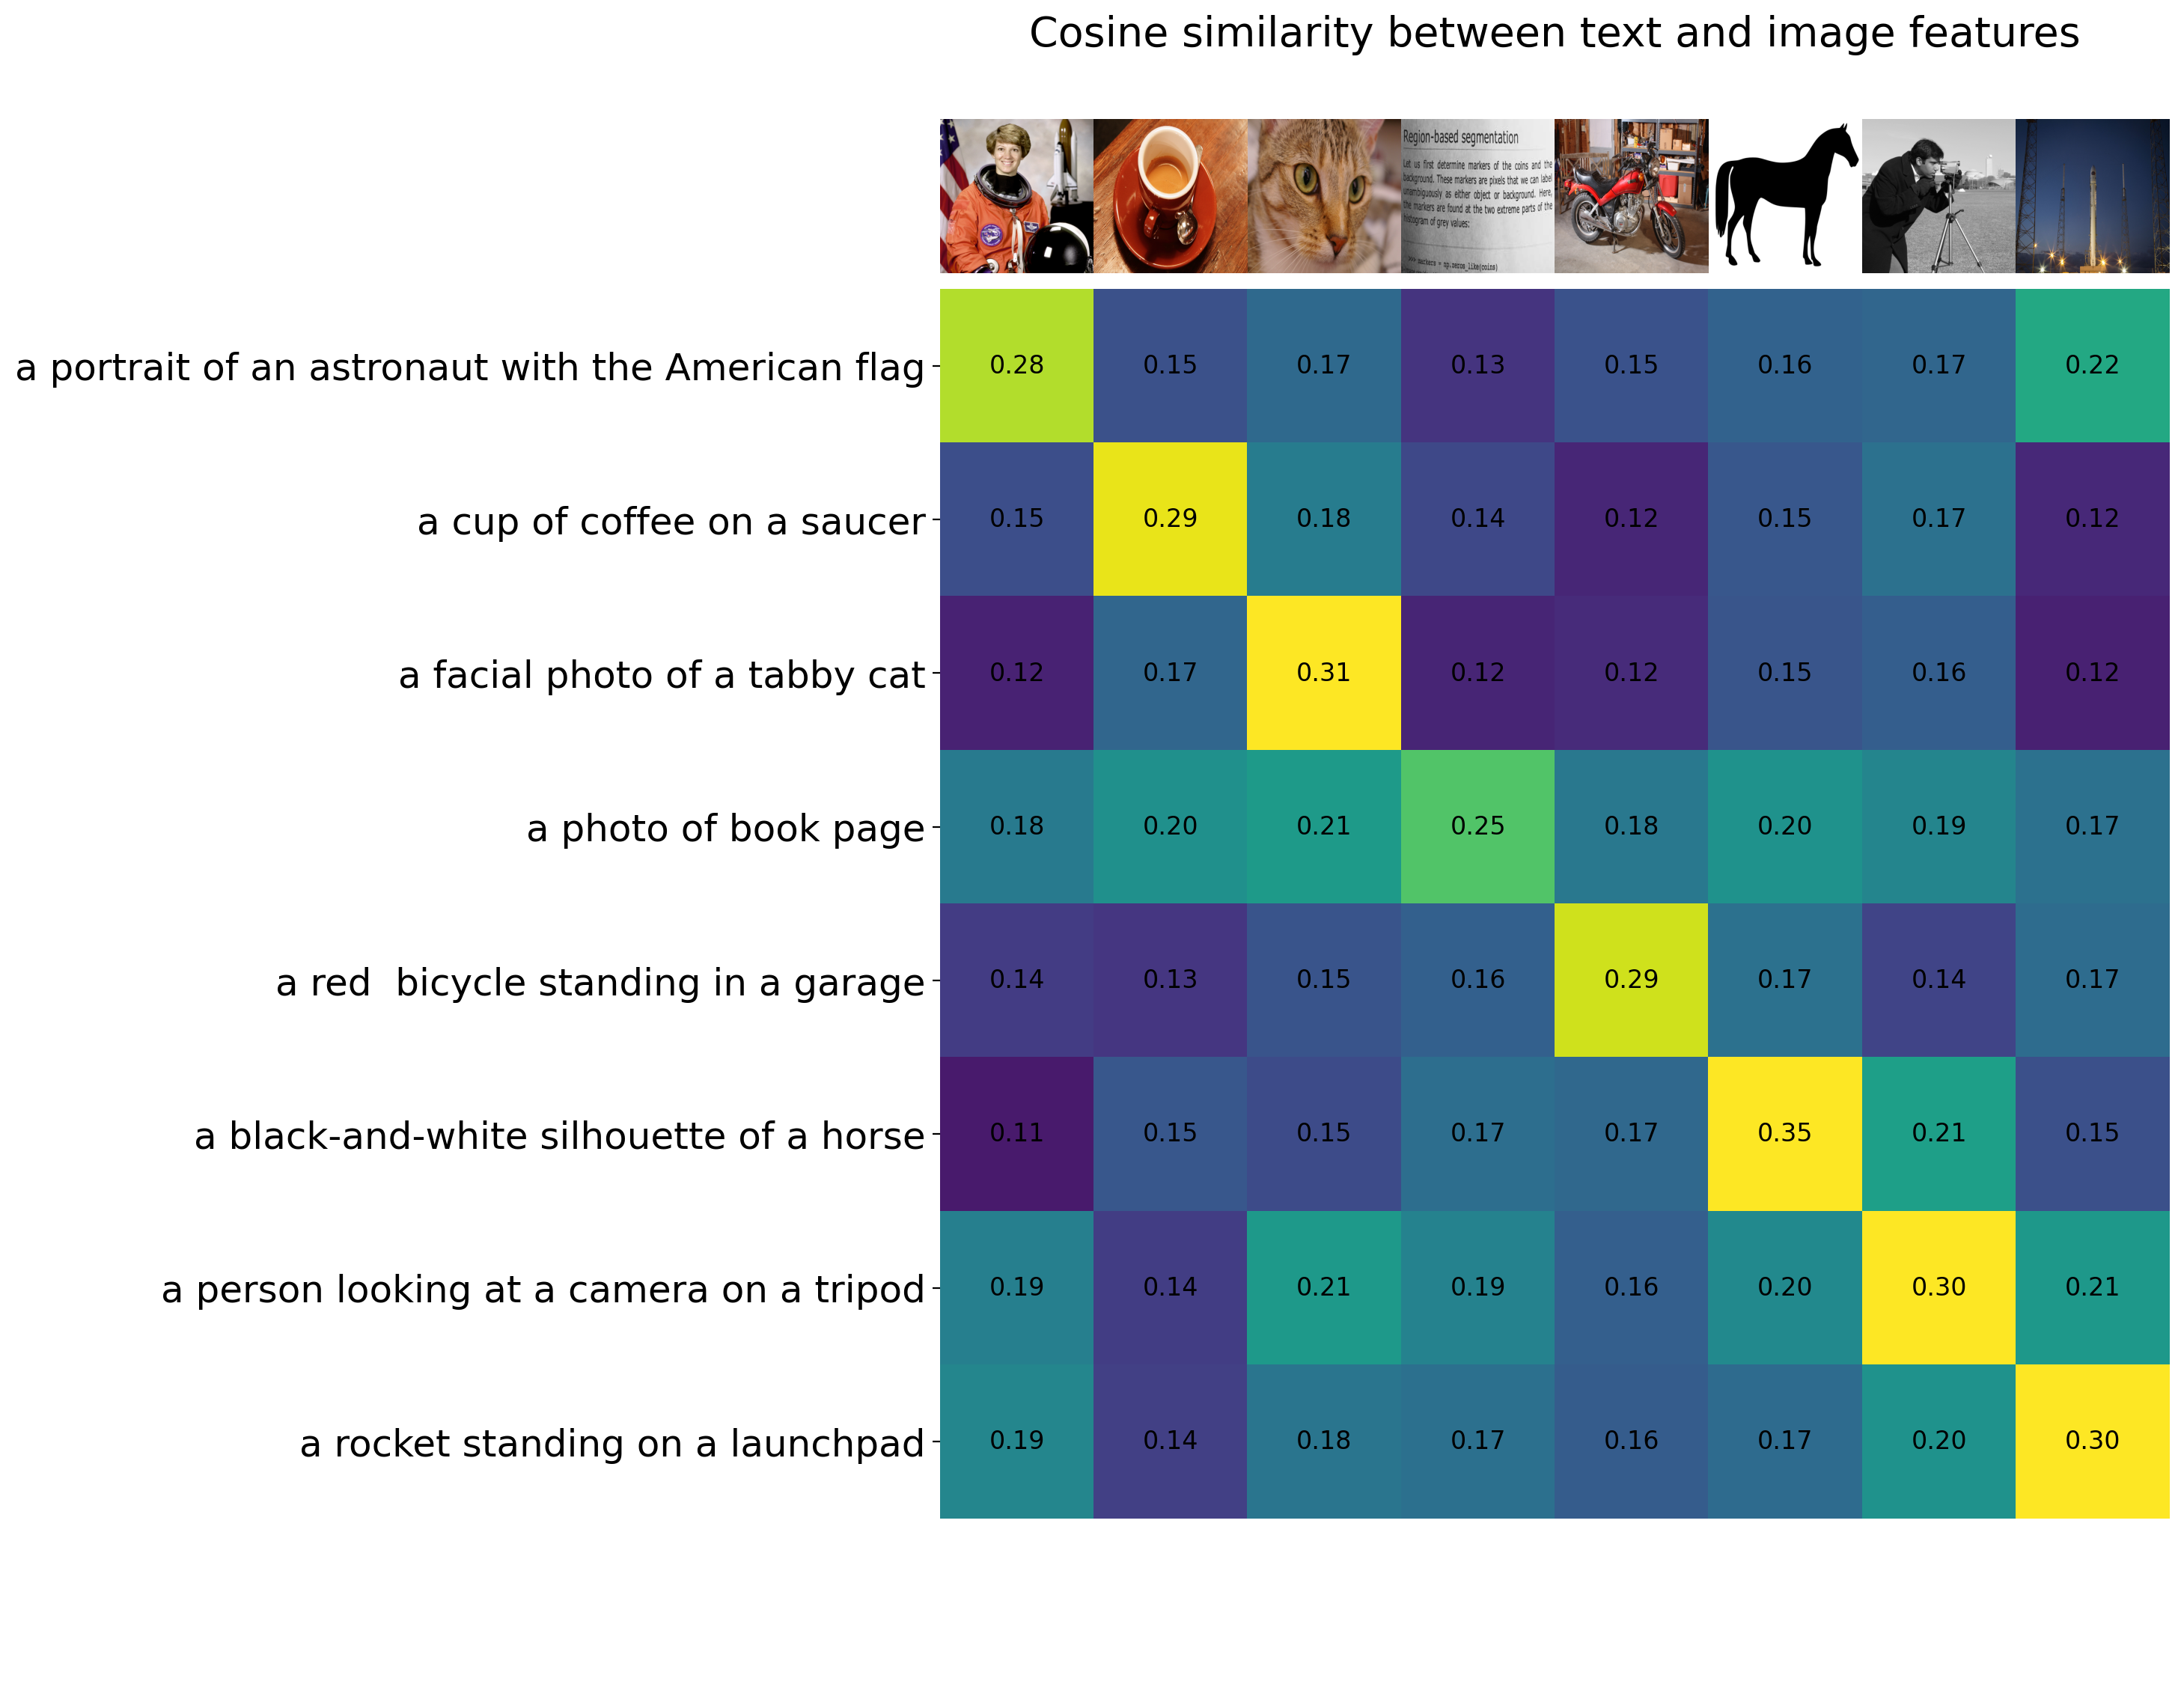

In [13]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

# Zero-Shot Image Classification

You can classify images using the cosine similarity (times 100) as the logits to the softmax operation.

In [14]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

100%|██████████| 169001437/169001437 [00:05<00:00, 28269632.84it/s]


Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache


In [15]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).cuda()

In [16]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

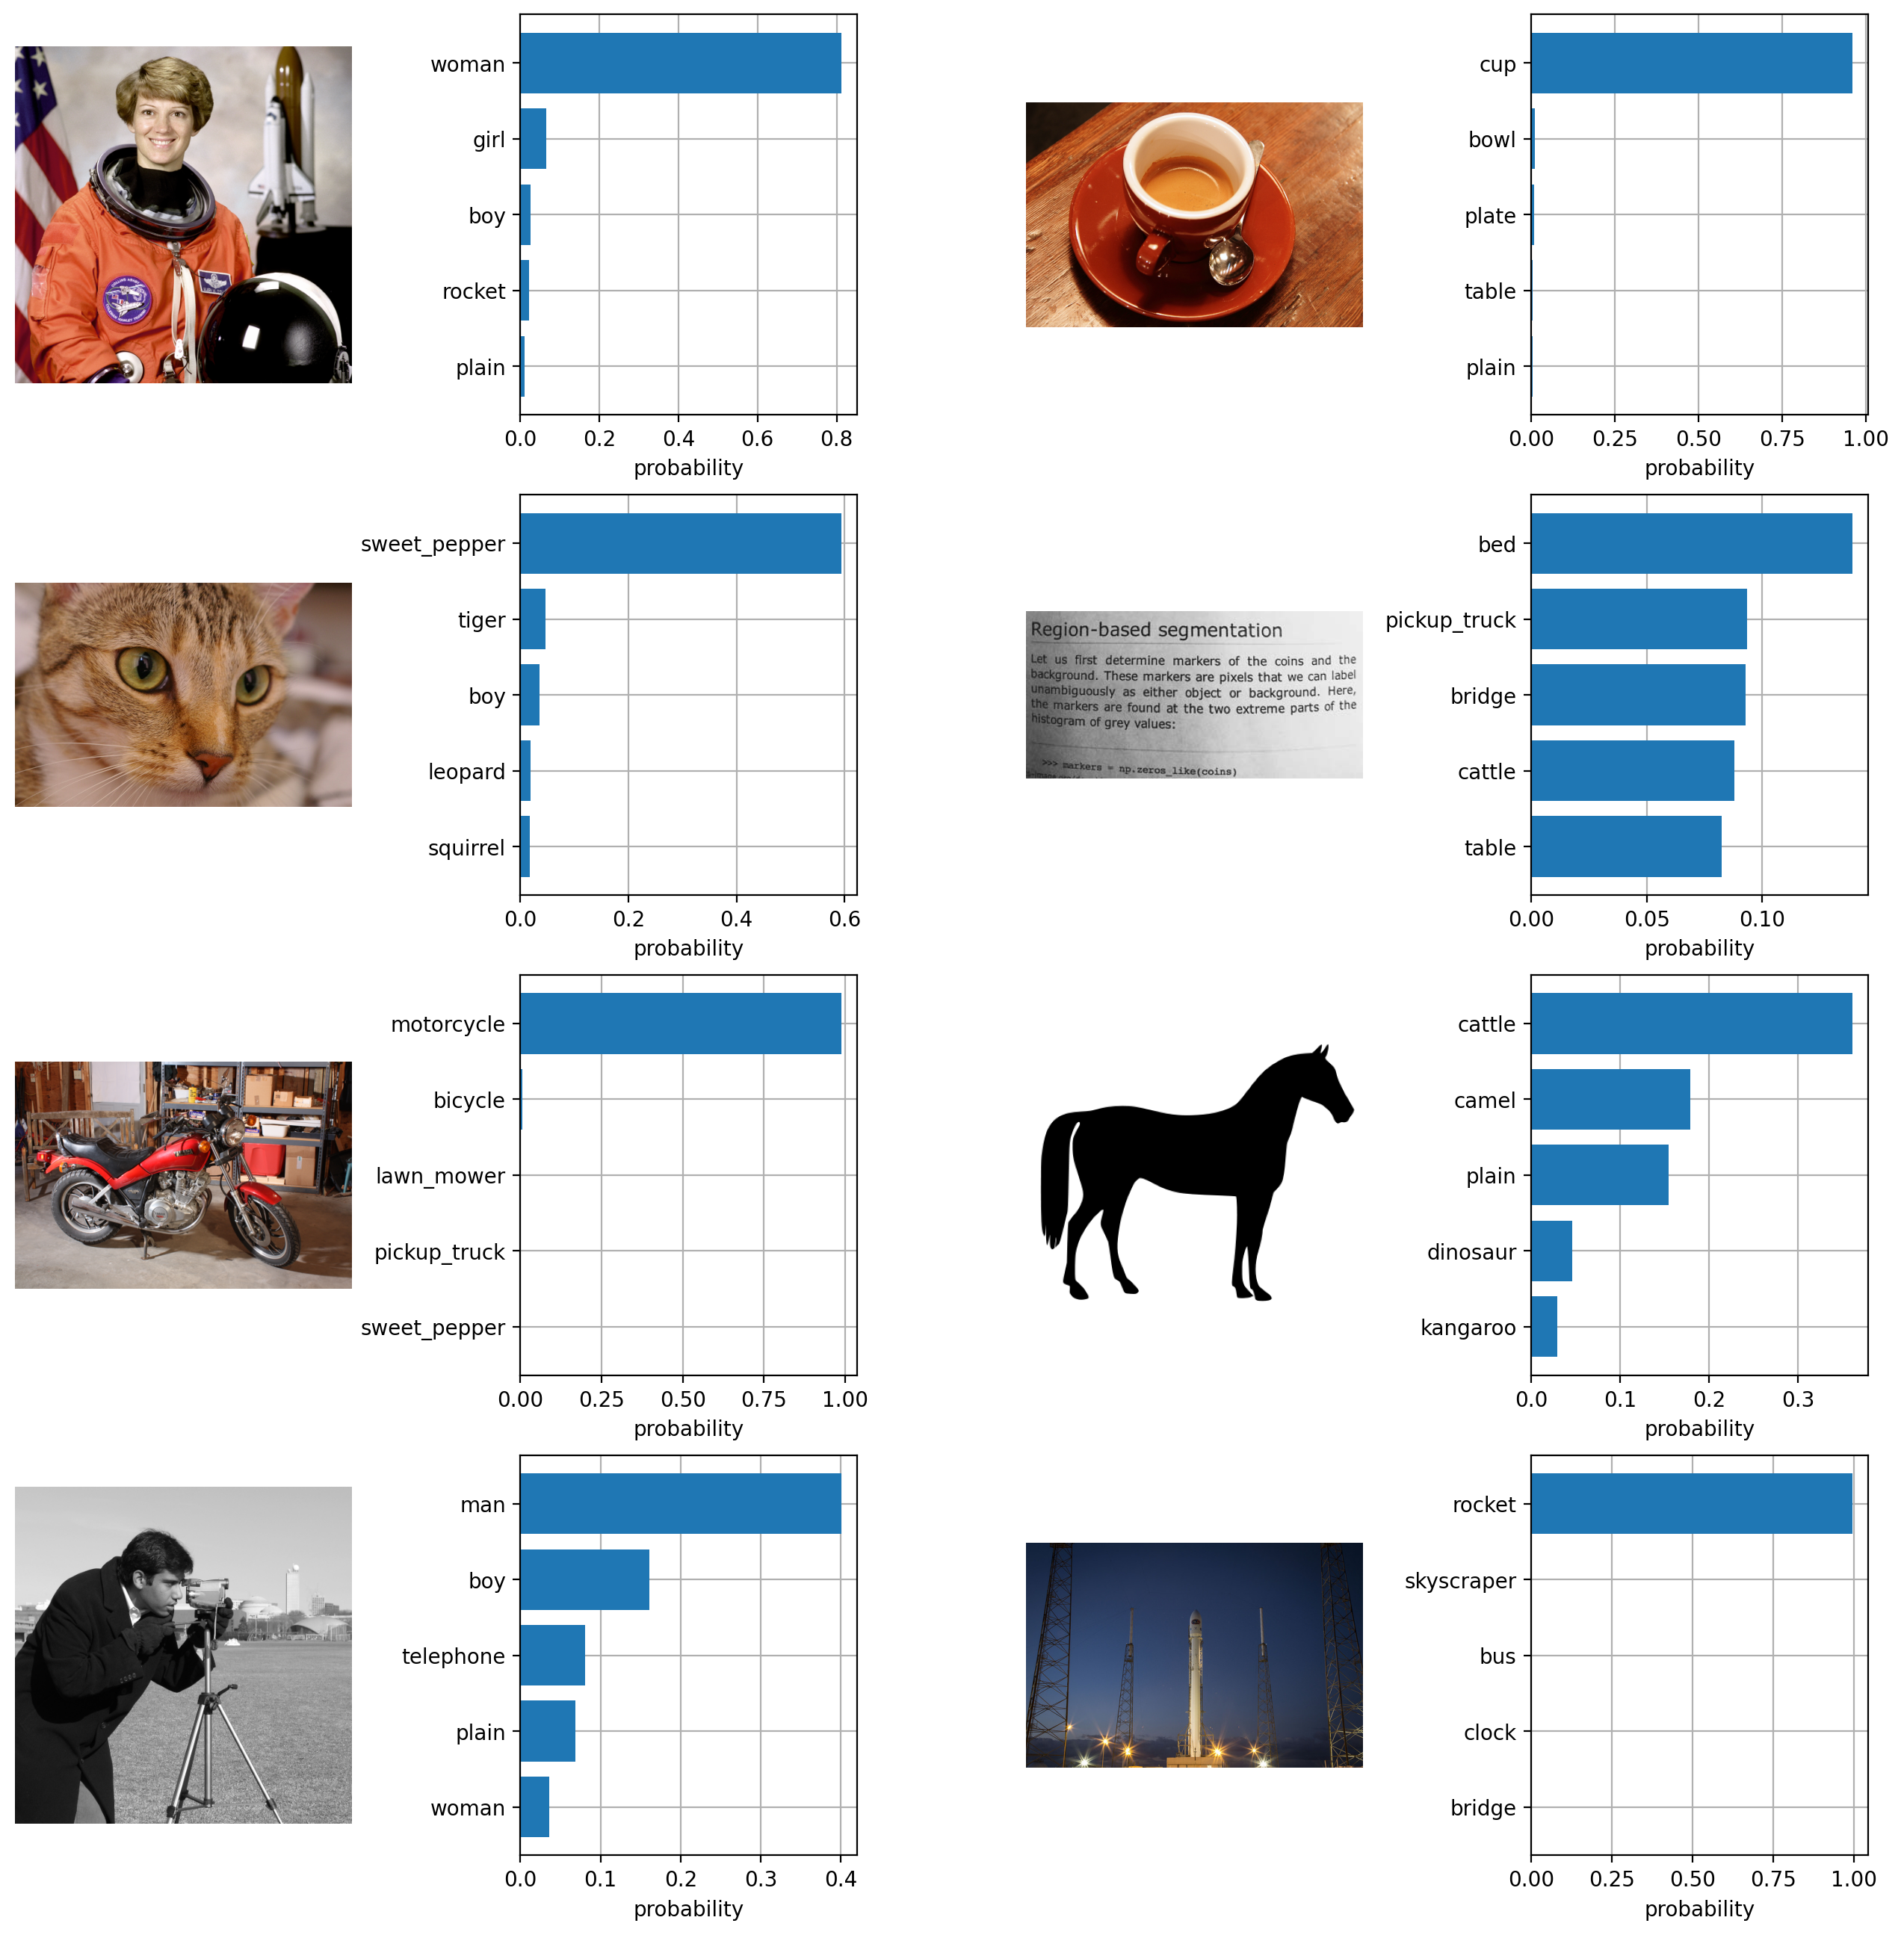

In [17]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()